# Build a liquid geometry using EMC.
Copyright ENEOS Corporation as contributors to Matlantis contrib project

Enhanced Monte Carlo\
https://montecarlo.sourceforge.net/emc/Welcome.html \
https://matsci.org/c/emc/50

P.J. in 't Veld and G.C. Rutledge, Macromolecules 2003, 36, 7358

In [1]:
import os
import sys
import numpy as np

from ase import Atoms, units
from ase.io import read, write, Trajectory
from ase.data import atomic_masses

from rdkit import Chem
from rdkit.Chem import AllChem, Draw


In [2]:
from pfcc_extras.visualize.view import view_ngl
from pfcc_extras.structure.ase_rdkit_converter import smiles_to_atoms, atoms_to_smiles

In [3]:
sys.path.insert(0, 'EMC_interface/src/emc_interface')
from emc_interface import EMCInterface

outputdir = './output'
os.makedirs(outputdir, exist_ok=True)

In [4]:
def set_elements_lammpsdata(atoms):
    mass_number = {int(np.round(m)):i for i, m in enumerate(atomic_masses)}
    masses = atoms.get_masses()
    numbers = [mass_number[int(np.round(m))] for m in masses] 
    atoms.numbers=numbers
    return atoms

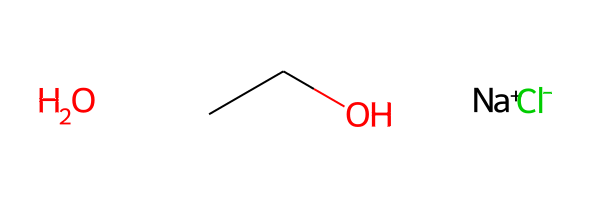

In [5]:
name_smiles_fractions = {"water":("O", 95), 
"alcohol":("CCO", 10),
"salt":("[Na+].[Cl-]", 5)}
smileses = [s for n,(s,f) in name_smiles_fractions.items()]
mols = [Chem.MolFromSmiles(smiles) for smiles in smileses]
view = Draw.MolsToGridImage(mols)
display(view)


settings = dict(
            name_smiles_fractions = name_smiles_fractions,
            ntotal = 2000,  # Number of atoms in the cell.
            density = 0.85, # Set slightly small density [g/cm3].
            field='pcff',
            ring_depth = 9,  #'auto', The max ring size in the molecules.
            build_dir = './build',
            lammps_prefix = 'liquid',
            project='liquid',
            seed=12345,
)

In [6]:
ntotal, settings['ntotal'] = settings['ntotal'], 100

builder = EMCInterface()
builder.verbose  =True
builder.setup('liquid', **settings)
builder.build()

basename =  f'{builder.settings["project"]}'
atoms = read(f'{basename}.pdb')
print(f'Number of atoms: {len(atoms)} ({settings["ntotal"]})')
settings['ntotal'] = ntotal

view_ngl([atoms], ['ball+stick'], replace_structure=True)

{'field': 'pcff', 'ntotal': 100, 'density': 0.85, 'ring_depth': 9, 'build_dir': './build', 'lammps_prefix': 'liquid', 'project': 'liquid', 'seed': 12345, 'emc_execute': 'false', 'groups': 'alcohol         CCO\nsalt            [Na+].[Cl-]\nwater           O', 'clusters': 'alcohol         alcohol,10\nwater           water,95\nsalt            salt,5'}
EMC Setup v4.1.3 (April 7, 2022), (c) 2004-2022 Pieter J. in 't Veld

Info: reading script from "./setup.esh"
Info: phase1 = {alcohol, water, salt}
Info: project = liquid
Info: ntotal = 100
Info: direction = x
Info: shape = 1
Info: force field type = "cff"
Info: force field name = "EMC_interface/EMC/v9.4.4/field/pcff/pcff"
Info: force field location = "."
Info: build for LAMMPS script in "./build"
Info: creating EMC build script "build.emc"
Info: assuming mol fractions
Info: creating LAMMPS run script "liquid.in"
Info: adding pressure sampling



(* EMC: Enhanced Monte Carlo simulations *)

version 9.4.4, build Jul 27 2022 17:22:21, date Thu

In [7]:
builder = EMCInterface()
builder.setup('liquid', **settings)

In [8]:
builder.build()

In [9]:
savedir = os.path.join(outputdir, f'build_{builder.settings["project"]}')
builder.savefiles(savedir)

In [10]:
basename =  f'{savedir}/{builder.settings["project"]}'
atoms_lammpsdata = read(f'{basename}.data', format='lammps-data')
atoms_lammpsdata = set_elements_lammpsdata(atoms_lammpsdata)
atoms = read(f'{basename}.pdb')

view_ngl([atoms, atoms_lammpsdata], replace_structure=True)

In [11]:
import importlib
MODEL_VERSION='latest'
CALC_MODE='CRYSTAL_PLUS_D3'
def get_calculator(model_version=MODEL_VERSION, calc_mode=CALC_MODE):

    spec = importlib.util.find_spec('pfp_api_client')
    if spec is None:
        from ase.calculators.emt import EMT
        calculator = EMT()
        return calculator

    from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
    from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode 
    if isinstance(calc_mode, str):
        calc_mode = getattr(EstimatorCalcMode, calc_mode)
    estimator = Estimator(model_version=model_version, calc_mode=calc_mode)
    calculator = ASECalculator(estimator)
    return calculator 

In [12]:
from ase.optimize import BFGS
atoms.calc = get_calculator()
opt = BFGS(atoms)
opt.run(steps=5)

/home/jovyan/.local/lib/python3.7/site-packages/pfp_api_client/__init__.py:36: UserWarning: New version of pfp-api-client is available. Please consider upgrading by `pip install -U pfp-api-client`.
  f"New version of {package_name} is available. Please consider"


      Step     Time          Energy         fmax
BFGS:    0 05:55:32    -6939.758253        4.7280
BFGS:    1 05:58:10    -6964.605104        2.8570
BFGS:    2 06:01:07    -6974.414727        1.4809
BFGS:    3 06:04:05    -6990.498553        2.6996
BFGS:    4 06:07:16    -7000.948442        1.7939
BFGS:    5 06:10:29    -7012.283600        1.7338
BFGS:    6 06:13:53    -7024.294307        2.0295
BFGS:    7 06:16:21    -7040.550547        2.9958
BFGS:    8 06:18:42    -7057.967199        4.3246
BFGS:    9 06:20:58    -7069.645240        4.3399
BFGS:   10 06:23:13    -7074.972493        4.4145


False

In [13]:
view_ngl(opt.atoms)